# Project Wine (Part 3a)
## Data Analysis with Linear Regression
<hr>
This notebook is the third part of the Project. We separate the project into several different notebooks (in line with the project guidelines):
1. Data Acquisition ([Red Wine Data Acquisition](Wine Data Acquisition.ipynb))
2. Data Exploration ([Preprocessing](Project_Preprocess.ipynb))
3. Data Analysis and Interpretation (Linear Regression (This Notebook), [scikit-learn](Project_Sklearn.ipynb))

This allows us to work together in a more efficient manner, click on the links of the notebook to navigate around the project.

Comments are available in the code snippets to aid in explaination.


In part 3a of this project, we will analyze the data with Linear Regression to find out if this is a model to predict wine quality.

In [62]:
# Import libraries

# math library
import numpy as np

# visualization library
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt

# machine learning library
from sklearn.linear_model import LinearRegression

# 3d visualization
from mpl_toolkits.mplot3d import axes3d

#import k-fold
from sklearn.model_selection import KFold

from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

# remove warning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

We selected the train data and test data with ```np.random.permutation```

In [63]:
#import data after z scoring
data = np.loadtxt('zscore_data.txt', delimiter=';')

# number of data
n = data.shape[0]
print(n)

#select the train data and test data
idx = np.random.permutation(range(n))
idx_test = idx[:271]
idx_train = idx[271:1471]
#print(idx_train)
#print(len(idx_train))
#print(len(idx_test))
train_data = data[idx_train,:]
test_data = data[idx_test, :]

#input the data, X
X = np.ones([1200, 2])
X [:, 0] = train_data[:, 0]
X [:, 1] = train_data[:, 1]
#print(X.shape)

#input y
y = np.ones([1200, 1])
y [:, 0] = train_data[:, 2]
#print (y)

1471


### Define the predictive and loss function

In [64]:
#define the predictive function
def pred_f (X, w):
    y_pred = X.dot(w)
    return y_pred
#print(pred_f(X,w))

In [65]:
#define the loss function
def loss_reg(w,X,y,reg): 
    n = len(y)
    w = w.squeeze()[:,None]
    y_pred = pred_f(X,w)
    loss = 1/n* (y_pred - y).T.dot(y_pred - y) 
    d = w.shape[0]
    loss += reg/d * w.T.dot(w)
    return loss
#print(mse_f(X, w, y))

In [66]:
#compute optimum w_solution
def compute_w_solution(X,y,reg):  #the method to determine w by minimizing the loss
    initial_w = np.zeros((X.shape[1],1))
    result = minimize(loss_reg, initial_w, args=(X,y,reg), method='Powell', options={'maxiter':100})
    w_solution = np.array(result.x)[:,None]
    loss_solution = loss_reg(w_solution,X,y,reg)
    return w_solution, loss_solution

In [72]:
#draw graph determine hyper-parameter
def loss_plot (hyper_para, loss_tab):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

   # Generate the values
    x_vals = hyper_para[:, 0]
    y_vals = hyper_para[:, 1]
    z_vals = loss_tab

   # Plot the values
    ax.scatter(x_vals, y_vals, z_vals, c = 'b', marker='o')
    ax.set_xlabel('d, learning capacity')
    ax.set_ylabel('reg, regularization parameter')
    ax.set_zlabel('loss')

In [73]:
#create a mesh grid
list_d = list(range(1,11))
m1, m2 = np.meshgrid(list_d, np.linspace(0,10,20)) 
hyper_para = np.ones([np.prod(m1.shape),2]) 
hyper_para[:,0] = m1.reshape(-1)
hyper_para[:,1] = m2.reshape(-1)
#print(hyper_para)
#print(hyper_para.shape)

[ 2.09473567  2.0967135   2.09853234  2.10717054  2.1071314   2.09689054
  2.08062197  2.07016101  2.05764479  2.05426772  2.71286215  2.34921353
  2.21360833  2.15883726  2.1556228   2.13878462  2.12378022  2.13525576
  2.10288845  2.10020022  2.97334534  2.56621002  2.314411    2.22027409
  2.19386867  2.19332284  2.17152766  2.10635099  2.11346571  2.09526375
  3.22693934  2.75049703  2.40667165  2.24353197  2.23359483  2.19352138
  2.16393687  2.15974982  2.14048313  2.11690161  3.47812746  2.91179775
  2.30171236  2.28879317  2.27865254  2.23663214  2.19138499  2.16757377
  2.15536741  2.13680359  3.727869    3.0474543   2.39768868  2.32448246
  2.26476929  2.26852727  2.22383034  2.19120701  2.1716859   2.14305319
  3.97649549  3.17082088  2.14821802  2.20491798  2.2162102   2.30148275
  2.24999775  2.21481247  2.19089398  2.16099611  4.22415349  3.28890345
  2.15206597  2.16862352  2.21376366  2.29503287  2.19860602  2.23354627
  2.20584012  2.18175387  4.47091887  3.37252196  2

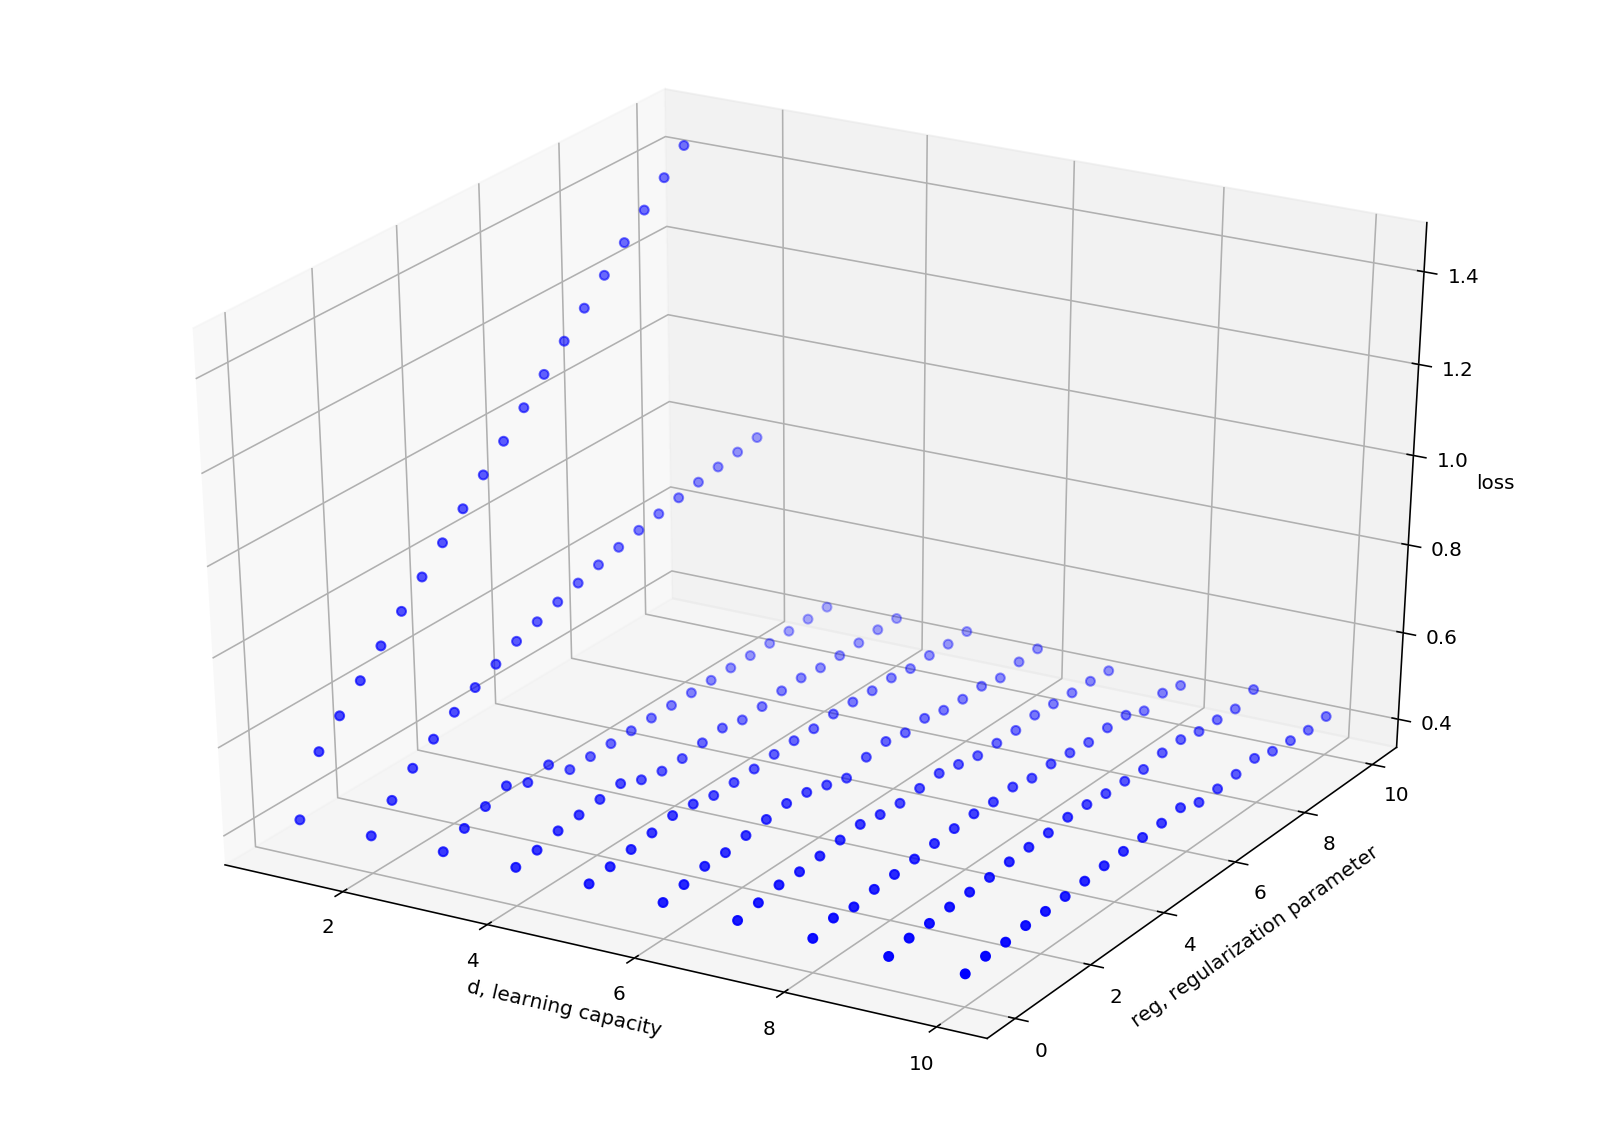

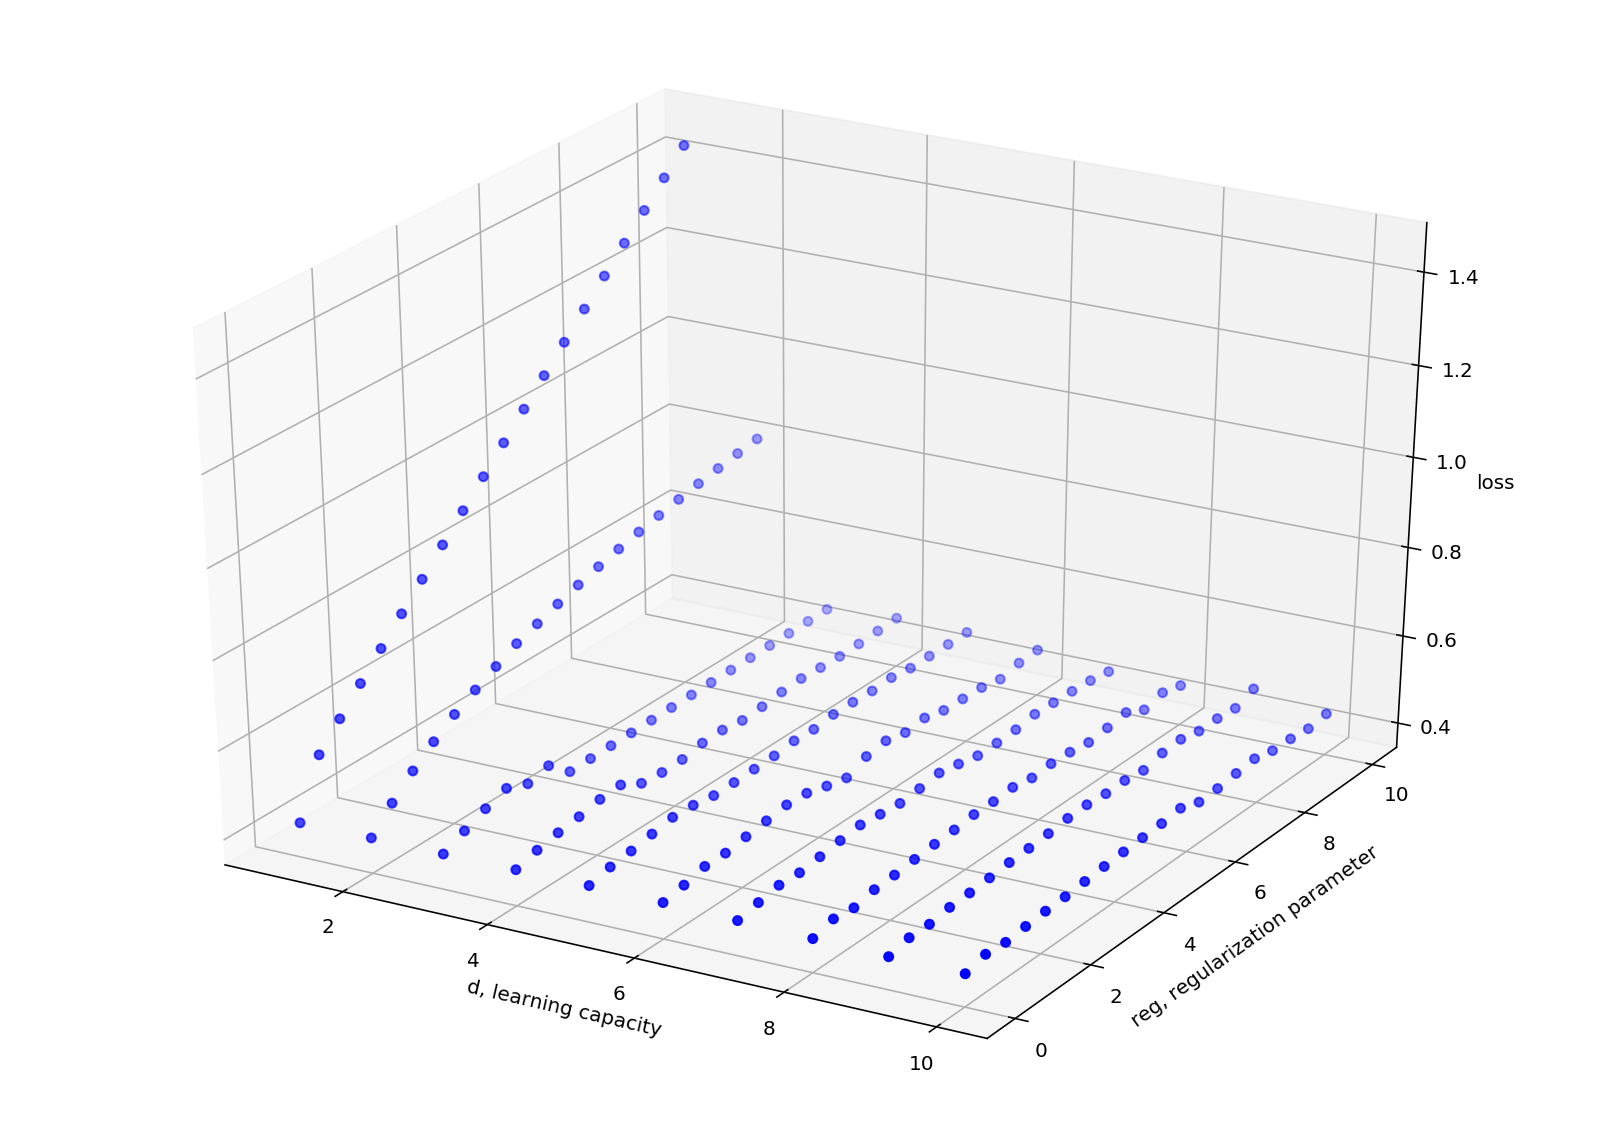

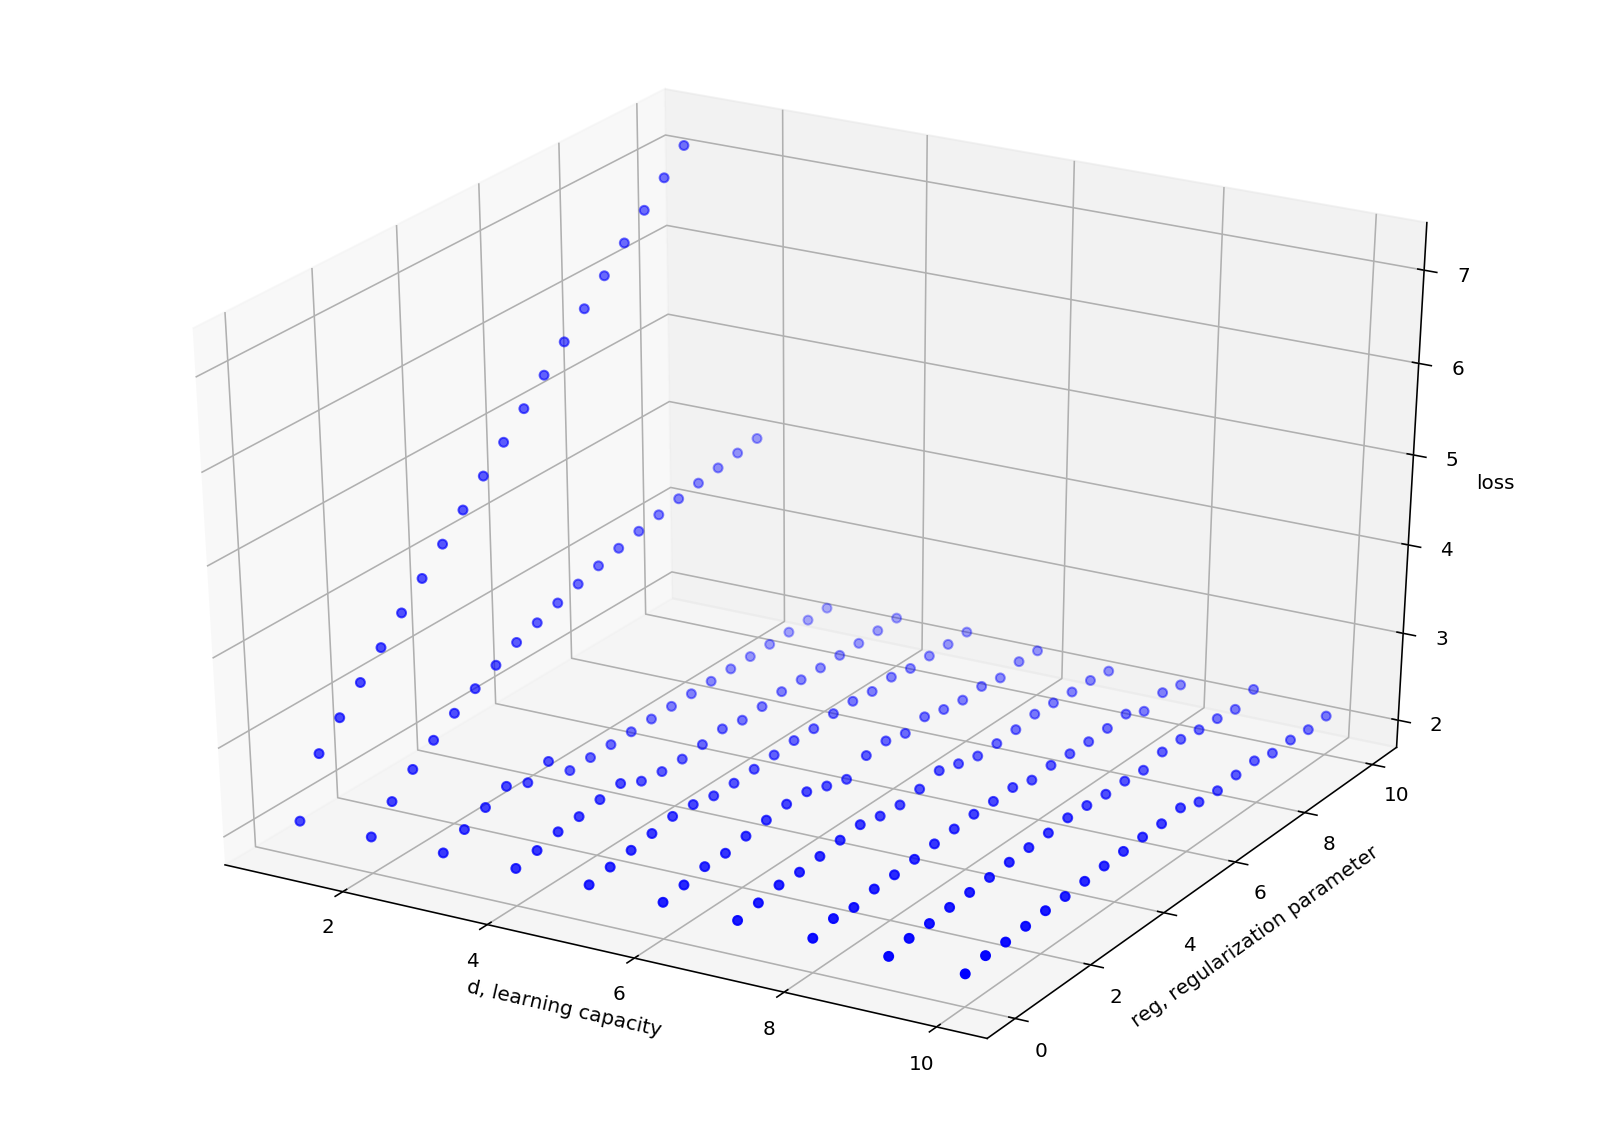

In [74]:
#determine the optimum hyper-parameter, by K-fold
kf = KFold(n_splits=4)
#create loss table for training loss, validation loss and total loss
train_loss_tab = np.zeros(hyper_para.shape[0])
val_loss_tab = np.zeros(hyper_para.shape[0])
mean_loss_tab = np.zeros(hyper_para.shape[0])
# create for loop1(k-fold)
for train_index,test_index in kf.split(X):
        #print("Train Index:",train_index,",Test Index:",test_index)
        train_X, val_X = X[train_index],X[test_index]
        train_y, val_y = y[train_index],y[test_index]
        #create for loop2 to test hyper parameter combination
        for i in range(hyper_para.shape[0]):
            d = int(hyper_para[i, 0])
            #create polynomial format for train_x
            poly = PolynomialFeatures(d)
            train_X_poly = poly.fit_transform(train_X)
            #calculate optimal w
            train_w_solution, train_loss_solution = compute_w_solution(train_X_poly,train_y,hyper_para[i, 1])
            #update training loss table
            train_loss_tab[i] = train_loss_tab[i] + train_loss_solution
            val_X_poly = poly.fit_transform(val_X)
            #calculate loss based on validation data
            val_loss = loss_reg(train_w_solution,val_X_poly,val_y,hyper_para[i, 1])
            #update validation loss table
            val_loss_tab[i] = val_loss_tab[i] + val_loss
            #update total loss table
            mean_loss_tab[i] = mean_loss_tab[i] + train_loss_tab[i] + val_loss_tab[i]
train_loss_tab = train_loss_tab/4
val_loss_tab = val_loss_tab/4
mean_loss_tab = mean_loss_tab/4
#plot 
loss_plot (hyper_para, train_loss_tab)
loss_plot (hyper_para, val_loss_tab)
loss_plot (hyper_para, mean_loss_tab)
#return the address of combination that gives minimum total loss
print(mean_loss_tab)

In [80]:
poly = PolynomialFeatures(4)
X_poly = poly.fit_transform(X)
w_solution_f, train_loss_solution = compute_w_solution(X_poly,y,0)
#print(w_solution_f)
test_X = np.ones([271, 2])
test_X[:, 0:1] = test_data[:, 0:1]
test_X_poly = poly.fit_transform(test_X)
#print(test_X_poly.shape)
test_y = np.ones([271, 1])
test_y[:, 0] = test_data[:, 2]
test_loss = loss_reg(w_solution_f,test_X_poly,test_y,0)
print(test_loss)

[[ 2.00922578]]


### Plotting of data on 3D graph

(1471, 15)
(15, 1)


Text(0.5,0,'quality')

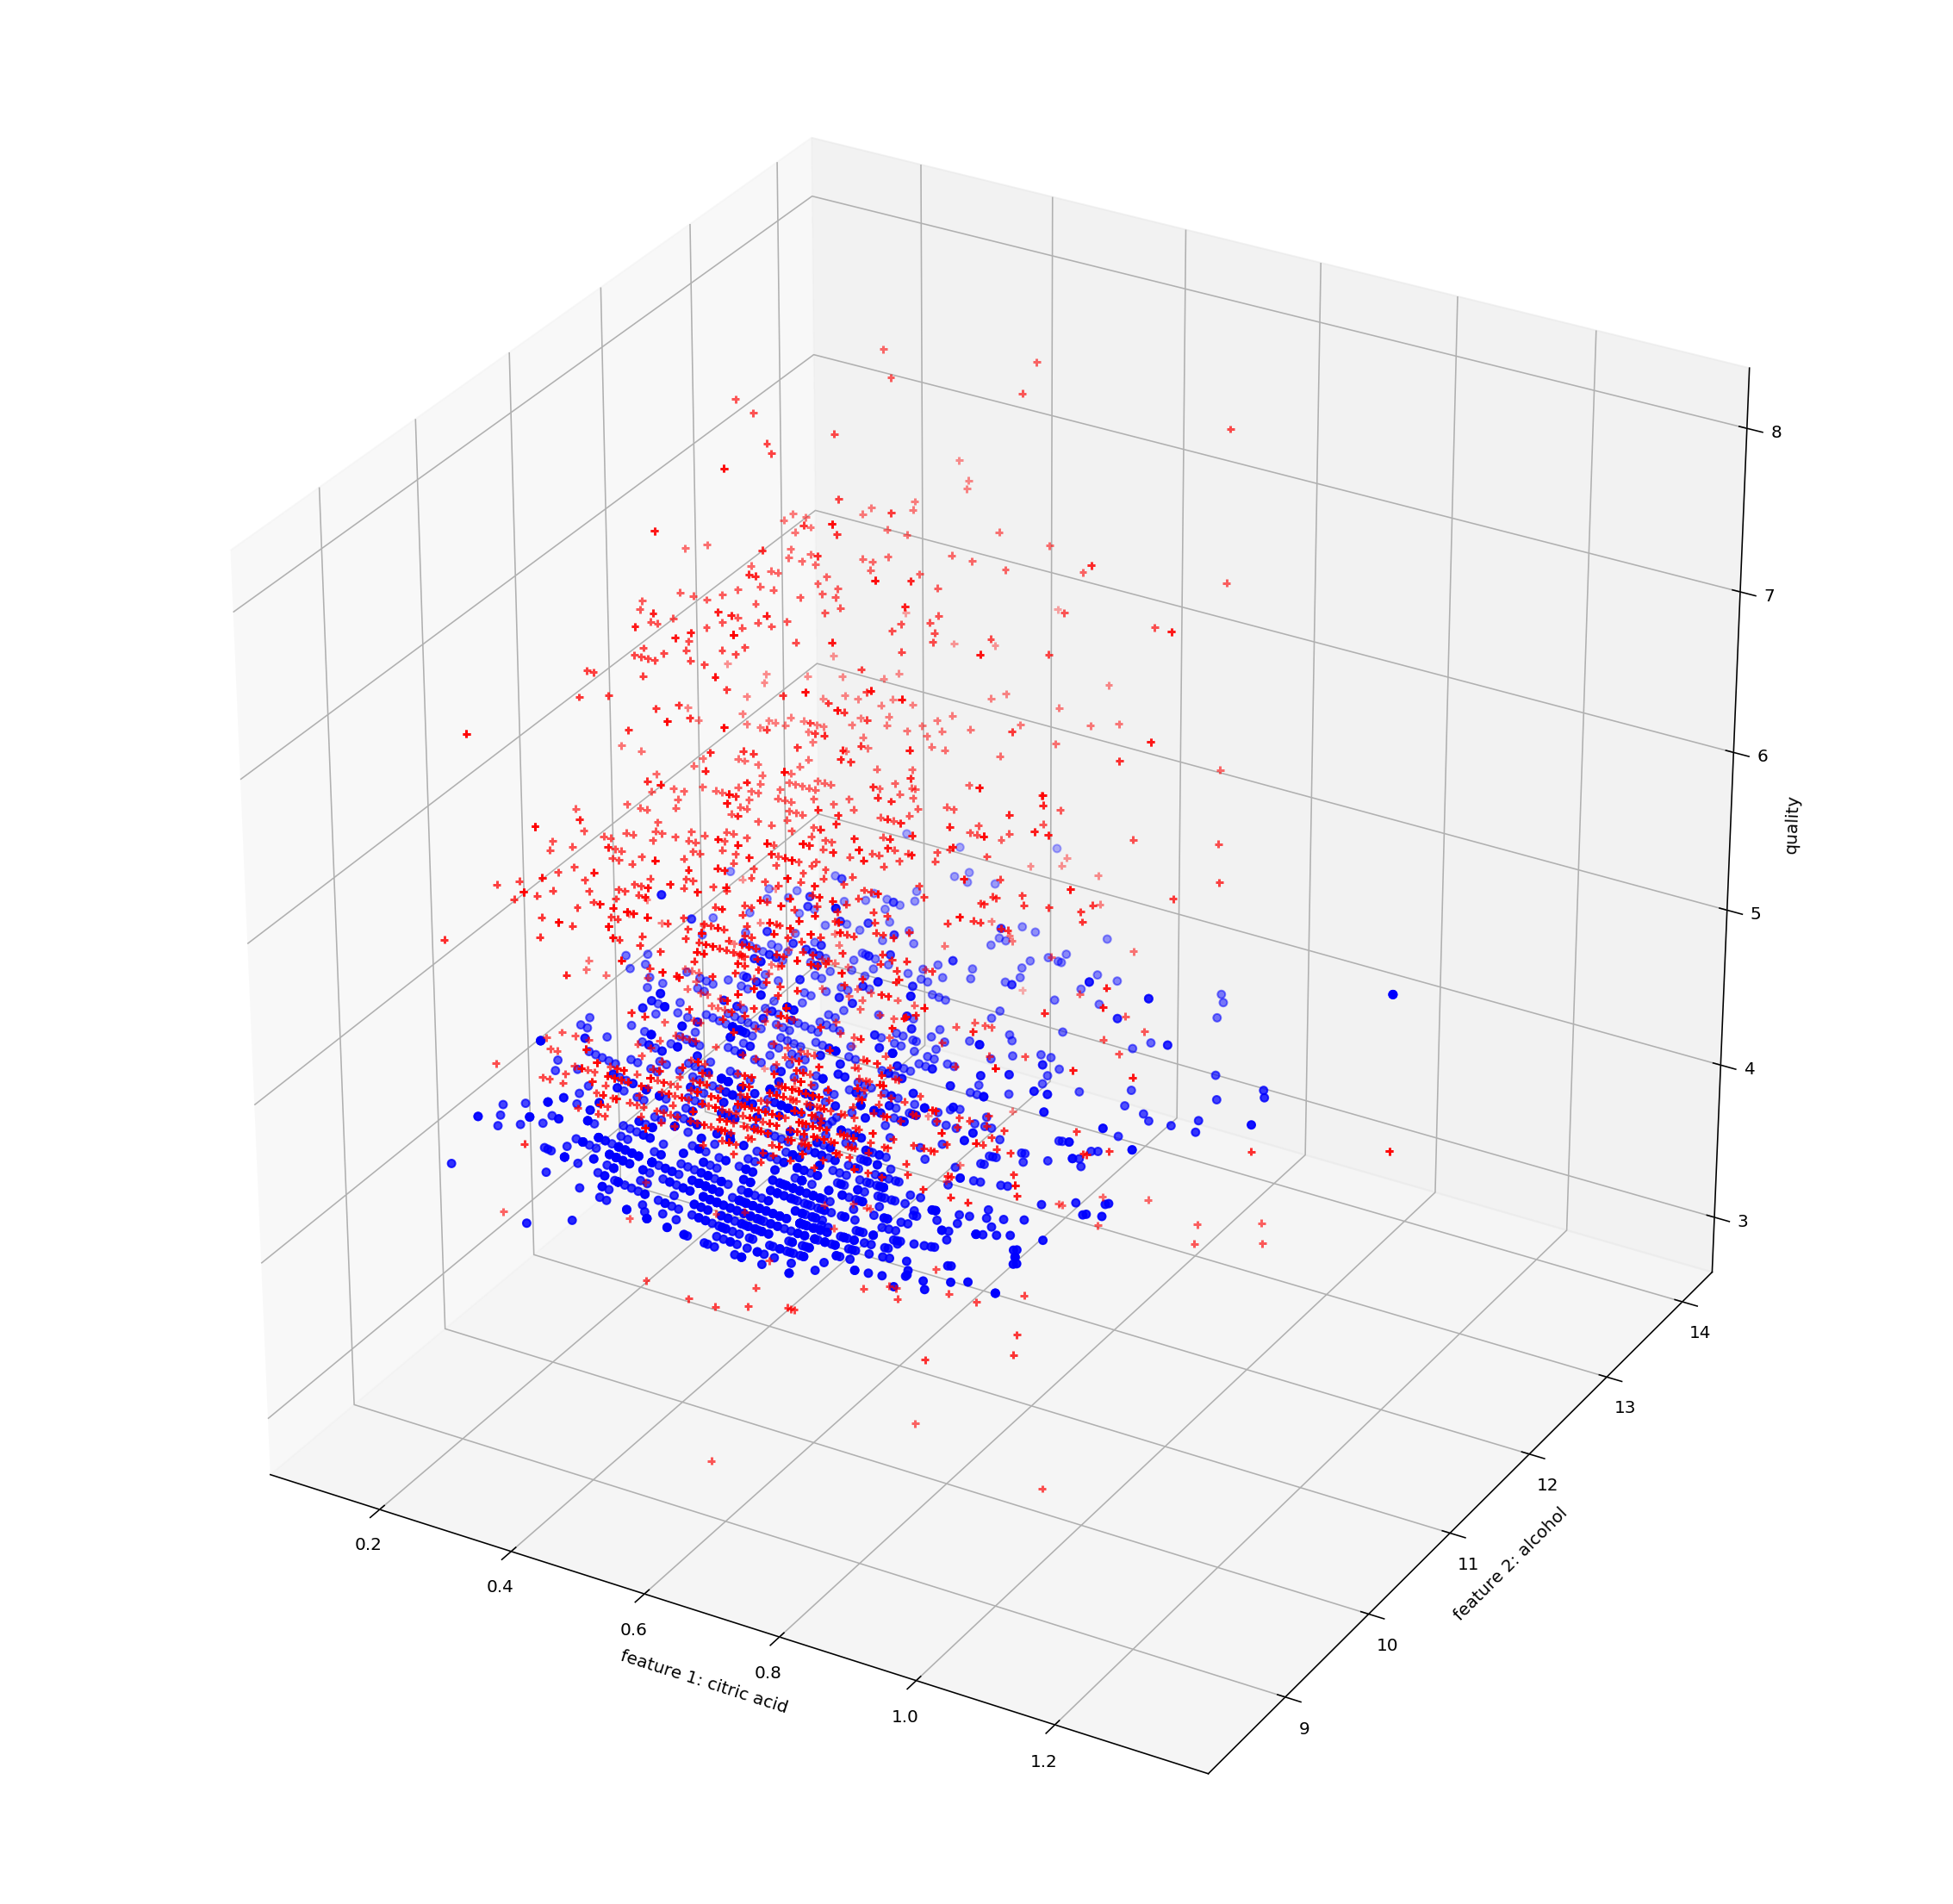

In [84]:
#visualization of all data
X_origin = np.ones([1471, 2])
X_origin[:, 0:1] = data[:,0:1]
X_origin_poly = poly.fit_transform(X_origin)
print(X_origin_poly.shape)
print(w_solution_f.shape)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1, projection='3d')

   # Generate the values
x_vals = data[:, 0]
y_vals = data[:, 1]
z_vals1 = pred_f (X_origin_poly, w_solution_f)
z_vals2 = data[:, 2]

   # Plot the values of both predictive value and actual value
ax.scatter(x_vals, y_vals, z_vals1, c = 'b', marker='o')
ax.scatter(x_vals, y_vals, z_vals2, c = 'r', marker='+')
ax.set_xlabel('feature 1: citric acid')
ax.set_ylabel('feature 2: alcohol')
ax.set_zlabel('quality')


Text(0.5,0,'quality')

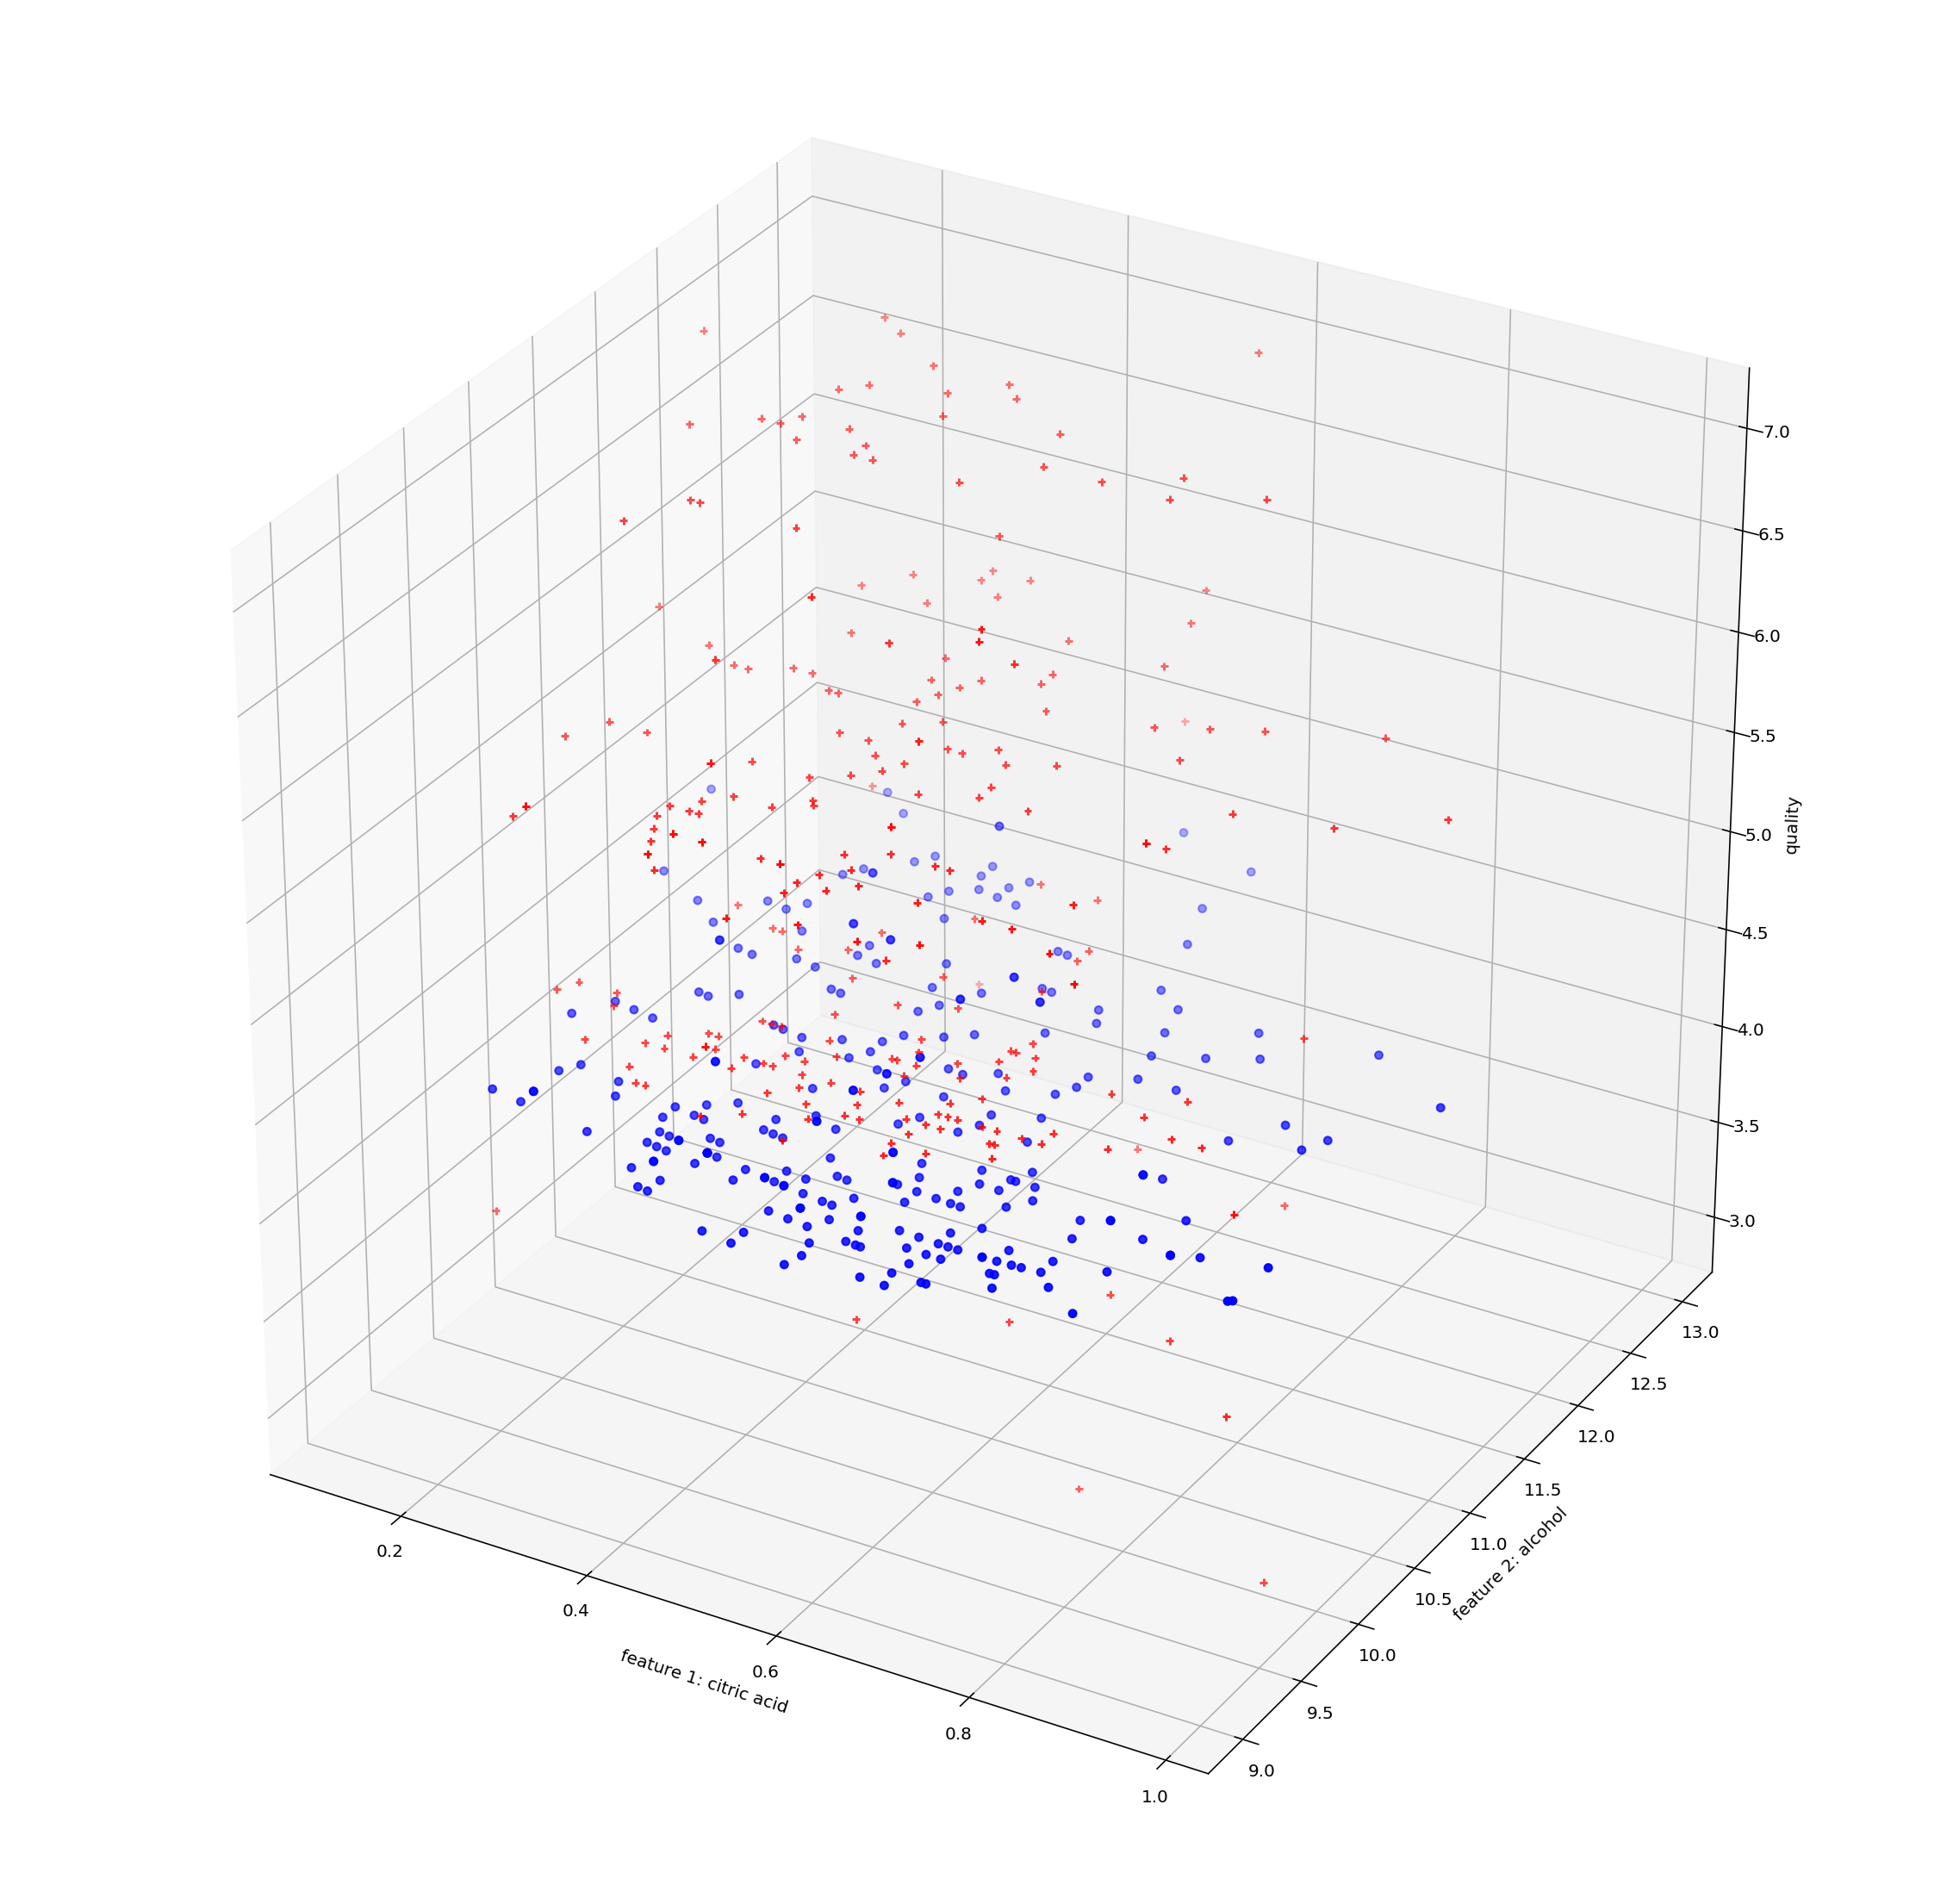

In [85]:
#visualization of test data
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1, projection='3d')

   # Generate the values
x_vals = test_data[:, 0]
y_vals = test_data[:, 1]
z_vals1 = pred_f (test_X_poly, w_solution_f)
z_vals2 = test_data[:, 2]

   # Plot the values of both predictive value and actual value
ax.scatter(x_vals, y_vals, z_vals1, c = 'b', marker='o')
ax.scatter(x_vals, y_vals, z_vals2, c = 'r', marker='+')
ax.set_xlabel('feature 1: citric acid')
ax.set_ylabel('feature 2: alcohol')
ax.set_zlabel('quality')
